# Assignment 1: Detecting Chinese Characters
By Jacob Coles

## Preprocessing:

In [35]:
import json
import os
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.image as mpimg
import numpy as np
import PIL
from PIL import Image, ImageDraw
import io
from matplotlib.patches import Polygon
from matplotlib import path
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
from torch.utils.data import Dataset, DataLoader
from keep_shuffle import ResumableRandomSampler
from sklearn.metrics import mean_squared_error

Get the names of all the images we have on hand

In [36]:
img_filenames = [filename for filename in os.listdir("/scratch/lt2326-h21/a1/images")]

Get all the info/data for the original training set

In [37]:
train_info = json.load(open("/scratch/lt2326-h21/a1/info.json"))["train"]
with open("/scratch/lt2326-h21/a1/train.jsonl") as trainfile:
    train_data = [json.loads(x) for x in trainfile]

We will now structure all our data as a list, where each item is a dictionary which our_data = list()

In [38]:
our_data = list()
for item in zip(train_info, train_data):
    if item[0]["file_name"] in img_filenames:
        to_append = item[0]
        to_append["input_img"] = np.array(Image.open("/scratch/lt2326-h21/a1/images/"+item[0]["file_name"]))
        to_append["polygons"] = list()
        for annotation in item[1]["annotations"]:
            for sent in annotation:
                to_append["polygons"].append(sent["polygon"])
        for annotation in item[1]["ignore"]:
            to_append["polygons"].append(annotation["polygon"])

        our_data.append(to_append)

We'll go through all the polygons in our data and create a 2048x2048 (binary pixel) image where each image corresponds to an image/scene. 

In [40]:
img_indices = np.array([[x[1],x[0]] for x in np.ndindex(2048,2048)])
for image in our_data:
    output_img = np.full(2048**2, False)
    for polygon in image["polygons"]:
        polygon = np.array(polygon)
        poly_obj = Polygon(polygon, closed=True)
        xmax, ymax = polygon.max(axis=0)
        xmin, ymin = polygon.min(axis=0)
        out_truths = poly_obj.contains_points(img_indices[int(ymin*2048):int(ymax*2048)]) #speedy boi
        output_img[int(ymin*2048):int(ymax*2048)] = np.bitwise_or(output_img[int(ymin*2048):int(ymax*2048)], out_truths)
    image["output_img"] = output_img.reshape(2048,2048)

Inside our_data, the relevant information we have is:
- Input image as a np-array ["input_img"]
- Output image as np-array ["output_img"]

In [41]:
data_for_model = list()
for item in our_data:
    data_for_model.append([torch.tensor(item["input_img"]).type(torch.FloatTensor), torch.tensor(item["output_img"]).type(torch.FloatTensor)])

Split our dataset into train/test/validation sets

In [42]:
from torch.utils.data import random_split

train_len = int(len(data_for_model)*0.7)
test_val_len = int(len(data_for_model)) - train_len

train_data, test_val_data = random_split(data_for_model,[train_len, test_val_len])

test_len = int(len(test_val_data)/2)
val_len = int(len(test_val_data)) - test_len

test_data, val_data = random_split(test_val_data,[test_len, val_len])

Put these sets in batches. 

In [43]:
batch_size = 2
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)

## Model 1:

In [44]:
class Model1(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 5)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(4, return_indices=True)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 128, kernel_size = 5)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(4, return_indices=True)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 5)
        self.norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(4, return_indices=True)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 5)
        self.norm4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool2d(4, return_indices=True)

        self.unpool1 = nn.MaxUnpool2d(4)
        self.unconv1 = nn.ConvTranspose2d(512, 256, kernel_size = 5)
        self.relu5 = nn.LeakyReLU()
        self.unpool2 = nn.MaxUnpool2d(4)
        self.unconv2 = nn.ConvTranspose2d(256, 128, kernel_size = 5)
        self.relu6 = nn.LeakyReLU()
        self.unpool3 = nn.MaxUnpool2d(4)
        self.unconv3 = nn.ConvTranspose2d(128, 32, kernel_size = 5)
        self.relu7 = nn.LeakyReLU()
        self.unpool4 = nn.MaxUnpool2d(4)
        self.unconv4 = nn.ConvTranspose2d(32, 1, kernel_size = 5)
        self.relu8 = nn.LeakyReLU()
        self.norm0 = nn.BatchNorm2d(1)
        
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        pool1size = list(out.size())
        out, indices1 = self.pool1(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu2(out)
        pool2size = list(out.size())
        out, indices2  = self.pool2(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = self.relu3(out)
        pool3size = list(out.size())
        out, indices3  = self.pool3(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = self.relu4(out)
        pool4size = list(out.size())
        out, indices4  = self.pool4(out)
        
        out = self.unpool1(out, indices4, output_size = pool4size)
        out = self.unconv1(out)
        out = self.norm3(out)
        out = self.relu5(out)
        out = self.unpool2(out, indices3, output_size = pool3size)
        out = self.unconv2(out)
        out = self.norm2(out)
        out = self.relu6(out)
        out = self.unpool3(out, indices2, output_size = pool2size)
        out = self.unconv3(out)
        out = self.norm1(out)
        out = self.relu7(out)
        out = self.unpool4(out, indices1, output_size = pool1size)
        out = self.unconv4(out)
        out = self.norm0(out)
        out = self.relu8(out)
        
        out = self.sigmoid(out)

        return out

In [46]:
num_epochs = 5
learning_rate = 1

if (torch.cuda.is_available()):
    device = "cuda:3"
else:
    device = "cpu"

model1 = Model1(batch_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model1.parameters(),lr = learning_rate, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)



In [47]:
all_losses_list_model1 = list()
epoch_avg_loss_model1 = list()
for epoch in range(1, num_epochs + 1):
    
    # Keep track of loss
    current_loss = 0.0
    total_loss = 0.0
    avg_loss = 0.0
    
    # Training model
    model1.train()
    for iteration, (input_image, target_image) in enumerate(train_dataloader):
        
        input_image = input_image.permute(0,3,1,2)

        optimizer.zero_grad()
        
        output = model1(input_image.to(device)).nan_to_num()

        # batch loss:
        loss = criterion(output.to(device), target_image.unsqueeze(1).to(device))

        loss.backward()

        optimizer.step()
        
        # Keep track of the loss: 
        current_loss = float(loss.item())
        total_loss += current_loss
        avg_loss = total_loss / (iteration+1)
        all_losses_list_model1.append(current_loss)
        
        print("Current loss: ", current_loss, "\nTotal loss: ", total_loss, "\nAverage loss: ", avg_loss)
    
    epoch_avg_loss_model1.append(avg_loss)
    scheduler.step()
    

Current loss:  0.9226373434066772 
Total loss:  0.9226373434066772 
Average loss:  0.9226373434066772
Current loss:  0.6882742643356323 
Total loss:  1.6109116077423096 
Average loss:  0.8054558038711548
Current loss:  0.7076345682144165 
Total loss:  2.318546175956726 
Average loss:  0.7728487253189087
Current loss:  0.7088167667388916 
Total loss:  3.0273629426956177 
Average loss:  0.7568407356739044
Current loss:  0.6899362802505493 
Total loss:  3.717299222946167 
Average loss:  0.7434598445892334
Current loss:  0.6802297830581665 
Total loss:  4.3975290060043335 
Average loss:  0.7329215010007223
Current loss:  0.677375078201294 
Total loss:  5.074904084205627 
Average loss:  0.7249862977436611
Current loss:  0.6762996912002563 
Total loss:  5.751203775405884 
Average loss:  0.7189004719257355
Current loss:  0.6753332614898682 
Total loss:  6.426537036895752 
Average loss:  0.7140596707661947
Current loss:  0.6746522188186646 
Total loss:  7.1011892557144165 
Average loss:  0.710

Current loss:  0.680752158164978 
Total loss:  55.960528790950775 
Average loss:  0.6824454730603753
Current loss:  0.6807593107223511 
Total loss:  56.641288101673126 
Average loss:  0.6824251578514835
Current loss:  0.6805675029754639 
Total loss:  57.32185560464859 
Average loss:  0.6824030429124832
Current loss:  0.680550217628479 
Total loss:  58.00240582227707 
Average loss:  0.6823812449679655
Current loss:  0.6804655194282532 
Total loss:  58.68287134170532 
Average loss:  0.6823589690895968
Current loss:  0.6804434657096863 
Total loss:  59.36331480741501 
Average loss:  0.6823369518093679
Current loss:  0.6804159283638 
Total loss:  60.04373073577881 
Average loss:  0.6823151219974865
Current loss:  0.6802815198898315 
Total loss:  60.72401225566864 
Average loss:  0.6822922725356027
Current loss:  0.680270791053772 
Total loss:  61.40428304672241 
Average loss:  0.682269811630249
Current loss:  0.6805763244628906 
Total loss:  62.0848593711853 
Average loss:  0.6822512018811

Current loss:  0.6756039261817932 
Total loss:  111.56910473108292 
Average loss:  0.680299419091969
Current loss:  0.675353467464447 
Total loss:  112.24445819854736 
Average loss:  0.6802694436275598
Current loss:  0.6756077408790588 
Total loss:  112.92006593942642 
Average loss:  0.6802413610808821
Current loss:  0.6756681203842163 
Total loss:  113.59573405981064 
Average loss:  0.6802139764060517
Current loss:  0.6753768920898438 
Total loss:  114.27111095190048 
Average loss:  0.6801851842375028
Current loss:  0.6751915216445923 
Total loss:  114.94630247354507 
Average loss:  0.6801556359381365
Current loss:  0.6750795245170593 
Total loss:  115.62138199806213 
Average loss:  0.680125776459189
Current loss:  0.6753334999084473 
Total loss:  116.29671549797058 
Average loss:  0.6800977514501203
Current loss:  0.6749557852745056 
Total loss:  116.97167128324509 
Average loss:  0.6800678562979365
Current loss:  0.6748889684677124 
Total loss:  117.6465602517128 
Average loss:  0.6

Current loss:  0.6713643074035645 
Total loss:  166.10224562883377 
Average loss:  0.6779683495054439
Current loss:  0.671030580997467 
Total loss:  166.77327620983124 
Average loss:  0.677940147194436
Current loss:  0.6710811853408813 
Total loss:  167.44435739517212 
Average loss:  0.6779123781181058
Current loss:  0.6708811521530151 
Total loss:  168.11523854732513 
Average loss:  0.6778840264005046
Current loss:  0.6708961725234985 
Total loss:  168.78613471984863 
Average loss:  0.6778559627303158
Current loss:  0.670749843120575 
Total loss:  169.4568845629692 
Average loss:  0.6778275382518768
Current loss:  0.67079758644104 
Total loss:  170.12768214941025 
Average loss:  0.677799530475738
Current loss:  0.6709054708480835 
Total loss:  170.79858762025833 
Average loss:  0.6777721730962633
Current loss:  0.6707457900047302 
Total loss:  171.46933341026306 
Average loss:  0.6777444008310793
Current loss:  0.6705472469329834 
Total loss:  172.13988065719604 
Average loss:  0.6777

Current loss:  0.6685948371887207 
Total loss:  20.7280792593956 
Average loss:  0.6686477180450193
Current loss:  0.6685386300086975 
Total loss:  21.396617889404297 
Average loss:  0.6686443090438843
Current loss:  0.6684744954109192 
Total loss:  22.065092384815216 
Average loss:  0.6686391631762186
Current loss:  0.6684837937355042 
Total loss:  22.73357617855072 
Average loss:  0.6686345934867859
Current loss:  0.6688796281814575 
Total loss:  23.402455806732178 
Average loss:  0.6686415944780623
Current loss:  0.6684980392456055 
Total loss:  24.070953845977783 
Average loss:  0.6686376068327162
Current loss:  0.6686104536056519 
Total loss:  24.739564299583435 
Average loss:  0.6686368729617145
Current loss:  0.6685233116149902 
Total loss:  25.408087611198425 
Average loss:  0.6686338845052218
Current loss:  0.6686057448387146 
Total loss:  26.07669335603714 
Average loss:  0.6686331629753113
Current loss:  0.6685379147529602 
Total loss:  26.7452312707901 
Average loss:  0.668

Current loss:  0.6685578227043152 
Total loss:  75.54880565404892 
Average loss:  0.6685735013632648
Current loss:  0.6682437658309937 
Total loss:  76.21704941987991 
Average loss:  0.668570608946315
Current loss:  0.6684333682060242 
Total loss:  76.88548278808594 
Average loss:  0.6685694155485734
Current loss:  0.6685635447502136 
Total loss:  77.55404633283615 
Average loss:  0.6685693649382427
Current loss:  0.6684340238571167 
Total loss:  78.22248035669327 
Average loss:  0.6685682081768656
Current loss:  0.6686352491378784 
Total loss:  78.89111560583115 
Average loss:  0.668568776320603
Current loss:  0.668175458908081 
Total loss:  79.55929106473923 
Average loss:  0.6685654711322624
Current loss:  0.6684997081756592 
Total loss:  80.22779077291489 
Average loss:  0.668564923107624
Current loss:  0.6685121655464172 
Total loss:  80.8963029384613 
Average loss:  0.6685644870947215
Current loss:  0.6682205200195312 
Total loss:  81.56452345848083 
Average loss:  0.668561667692

Current loss:  0.6680288314819336 
Total loss:  129.68653750419617 
Average loss:  0.6684873067226607
Current loss:  0.6683486104011536 
Total loss:  130.35488611459732 
Average loss:  0.6684865954594734
Current loss:  0.6682072877883911 
Total loss:  131.0230934023857 
Average loss:  0.6684851704203353
Current loss:  0.6680488586425781 
Total loss:  131.6911422610283 
Average loss:  0.6684829556397375
Current loss:  0.6681352853775024 
Total loss:  132.3592775464058 
Average loss:  0.6684811997293222
Current loss:  0.6685696244239807 
Total loss:  133.02784717082977 
Average loss:  0.6684816440745215
Current loss:  0.6679720878601074 
Total loss:  133.69581925868988 
Average loss:  0.6684790962934494
Current loss:  0.6682956218719482 
Total loss:  134.36411488056183 
Average loss:  0.6684781834853822
Current loss:  0.6684192419052124 
Total loss:  135.03253412246704 
Average loss:  0.6684778916953814
Current loss:  0.668036699295044 
Total loss:  135.70057082176208 
Average loss:  0.6

Current loss:  0.6677814722061157 
Total loss:  183.7960250377655 
Average loss:  0.668349181955511
Current loss:  0.6685649752616882 
Total loss:  184.4645900130272 
Average loss:  0.6683499638153159
Current loss:  0.6676424741744995 
Total loss:  185.1322324872017 
Average loss:  0.6683474097010892
Current loss:  0.667877197265625 
Total loss:  185.80010968446732 
Average loss:  0.6683457182894508
Current loss:  0.6678385138511658 
Total loss:  186.46794819831848 
Average loss:  0.668343900352396
Current loss:  0.6680289506912231 
Total loss:  187.1359771490097 
Average loss:  0.6683427755321775
Current loss:  0.6676586866378784 
Total loss:  187.80363583564758 
Average loss:  0.6683403410521266
Current loss:  0.6677595376968384 
Total loss:  188.47139537334442 
Average loss:  0.6683382814657604
Current loss:  0.6680706739425659 
Total loss:  189.139466047287 
Average loss:  0.6683373358561377
Current loss:  0.6676633358001709 
Total loss:  189.80712938308716 
Average loss:  0.668334

Current loss:  0.6675610542297363 
Total loss:  40.72753697633743 
Average loss:  0.6676645405956956
Current loss:  0.6679846048355103 
Total loss:  41.39552158117294 
Average loss:  0.6676697029221442
Current loss:  0.6675622463226318 
Total loss:  42.063083827495575 
Average loss:  0.6676679972618346
Current loss:  0.6674773097038269 
Total loss:  42.7305611371994 
Average loss:  0.6676650177687407
Current loss:  0.667701244354248 
Total loss:  43.39826238155365 
Average loss:  0.6676655751008254
Current loss:  0.6676251292228699 
Total loss:  44.06588751077652 
Average loss:  0.6676649622844927
Current loss:  0.6675655841827393 
Total loss:  44.73345309495926 
Average loss:  0.6676634790292427
Current loss:  0.6678128838539124 
Total loss:  45.40126597881317 
Average loss:  0.6676656761590172
Current loss:  0.6680287718772888 
Total loss:  46.06929475069046 
Average loss:  0.6676709384158037
Current loss:  0.6677445769309998 
Total loss:  46.73703932762146 
Average loss:  0.66767199

Current loss:  0.6675459146499634 
Total loss:  95.47686076164246 
Average loss:  0.6676703549765207
Current loss:  0.6679987907409668 
Total loss:  96.14485955238342 
Average loss:  0.6676726357804404
Current loss:  0.6675645112991333 
Total loss:  96.81242406368256 
Average loss:  0.6676718900943625
Current loss:  0.6675215363502502 
Total loss:  97.4799456000328 
Average loss:  0.6676708602741973
Current loss:  0.6677471399307251 
Total loss:  98.14769273996353 
Average loss:  0.6676713791834253
Current loss:  0.6682323217391968 
Total loss:  98.81592506170273 
Average loss:  0.6676751693358293
Current loss:  0.6675134301185608 
Total loss:  99.48343849182129 
Average loss:  0.6676740838377268
Current loss:  0.667794942855835 
Total loss:  100.15123343467712 
Average loss:  0.6676748895645142
Current loss:  0.6675500273704529 
Total loss:  100.81878346204758 
Average loss:  0.6676740626625667
Current loss:  0.6677125692367554 
Total loss:  101.48649603128433 
Average loss:  0.667674

Current loss:  0.6677336692810059 
Total loss:  149.56218373775482 
Average loss:  0.667688320257834
Current loss:  0.6680542826652527 
Total loss:  150.23023802042007 
Average loss:  0.6676899467574225
Current loss:  0.6674481630325317 
Total loss:  150.8976861834526 
Average loss:  0.6676888769179319
Current loss:  0.6675083637237549 
Total loss:  151.56519454717636 
Average loss:  0.6676880817056228
Current loss:  0.6675440073013306 
Total loss:  152.2327385544777 
Average loss:  0.6676874498003408
Current loss:  0.6676140427589417 
Total loss:  152.90035259723663 
Average loss:  0.6676871292455748
Current loss:  0.6677147150039673 
Total loss:  153.5680673122406 
Average loss:  0.6676872491836547
Current loss:  0.6675018072128296 
Total loss:  154.23556911945343 
Average loss:  0.6676864464045603
Current loss:  0.6677296757698059 
Total loss:  154.90329879522324 
Average loss:  0.6676866327380312
Current loss:  0.6676306128501892 
Total loss:  155.57092940807343 
Average loss:  0.6

Current loss:  0.6678178906440735 
Total loss:  6.675889551639557 
Average loss:  0.6675889551639557
Current loss:  0.667626678943634 
Total loss:  7.343516230583191 
Average loss:  0.6675923845984719
Current loss:  0.6675143837928772 
Total loss:  8.011030614376068 
Average loss:  0.667585884531339
Current loss:  0.6677323579788208 
Total loss:  8.678762972354889 
Average loss:  0.6675971517196069
Current loss:  0.6676859259605408 
Total loss:  9.34644889831543 
Average loss:  0.6676034927368164
Current loss:  0.6676324605941772 
Total loss:  10.014081358909607 
Average loss:  0.6676054239273072
Current loss:  0.6676715016365051 
Total loss:  10.681752860546112 
Average loss:  0.667609553784132
Current loss:  0.6676428318023682 
Total loss:  11.34939569234848 
Average loss:  0.6676115113146165
Current loss:  0.6674605011940002 
Total loss:  12.01685619354248 
Average loss:  0.6676031218634711
Current loss:  0.668354332447052 
Total loss:  12.685210525989532 
Average loss:  0.667642659

Current loss:  0.6673926115036011 
Total loss:  61.42657667398453 
Average loss:  0.6676801812389622
Current loss:  0.667397141456604 
Total loss:  62.09397381544113 
Average loss:  0.6676771378004422
Current loss:  0.6675823330879211 
Total loss:  62.76155614852905 
Average loss:  0.6676761292396708
Current loss:  0.6675928235054016 
Total loss:  63.429148972034454 
Average loss:  0.6676752523372048
Current loss:  0.6675091981887817 
Total loss:  64.09665817022324 
Average loss:  0.667673522606492
Current loss:  0.6675631999969482 
Total loss:  64.76422137022018 
Average loss:  0.6676723852600019
Current loss:  0.6675011515617371 
Total loss:  65.43172252178192 
Average loss:  0.6676706379773666
Current loss:  0.6673874855041504 
Total loss:  66.09911000728607 
Average loss:  0.6676677778513744
Current loss:  0.6674145460128784 
Total loss:  66.76652455329895 
Average loss:  0.6676652455329894
Current loss:  0.6677300930023193 
Total loss:  67.43425464630127 
Average loss:  0.66766588

Current loss:  0.6677782535552979 
Total loss:  116.1753140091896 
Average loss:  0.6676742184436184
Current loss:  0.6675195693969727 
Total loss:  116.84283357858658 
Average loss:  0.6676733347347804
Current loss:  0.6676656603813171 
Total loss:  117.5104992389679 
Average loss:  0.6676732911304994
Current loss:  0.6674966812133789 
Total loss:  118.17799592018127 
Average loss:  0.6676722933343575
Current loss:  0.6675671339035034 
Total loss:  118.84556305408478 
Average loss:  0.667671702551038
Current loss:  0.6679216623306274 
Total loss:  119.5134847164154 
Average loss:  0.6676730989743878
Current loss:  0.6677514314651489 
Total loss:  120.18123614788055 
Average loss:  0.667673534154892
Current loss:  0.6674758195877075 
Total loss:  120.84871196746826 
Average loss:  0.6676724418092169
Current loss:  0.6676090955734253 
Total loss:  121.51632106304169 
Average loss:  0.6676720937529763
Current loss:  0.6687756776809692 
Total loss:  122.18509674072266 
Average loss:  0.66

Current loss:  0.6680196523666382 
Total loss:  170.25548648834229 
Average loss:  0.6676685744640873
Current loss:  0.6677552461624146 
Total loss:  170.9232417345047 
Average loss:  0.667668913025409
Current loss:  0.6678297519683838 
Total loss:  171.59107148647308 
Average loss:  0.667669538857872
Current loss:  0.667805552482605 
Total loss:  172.2588770389557 
Average loss:  0.6676700660424639
Current loss:  0.6674776077270508 
Total loss:  172.92635464668274 
Average loss:  0.667669322960165
Current loss:  0.6675353646278381 
Total loss:  173.59389001131058 
Average loss:  0.6676688077358099
Current loss:  0.6677695512771606 
Total loss:  174.26165956258774 
Average loss:  0.6676691937263898
Current loss:  0.6676956415176392 
Total loss:  174.92935520410538 
Average loss:  0.667669294672158
Current loss:  0.6677109003067017 
Total loss:  175.59706610441208 
Average loss:  0.667669452868487
Current loss:  0.6677942276000977 
Total loss:  176.26486033201218 
Average loss:  0.66766

Current loss:  0.6676734685897827 
Total loss:  27.37401580810547 
Average loss:  0.6676589221489139
Current loss:  0.6679185628890991 
Total loss:  28.041934370994568 
Average loss:  0.6676651040712992
Current loss:  0.6676848530769348 
Total loss:  28.709619224071503 
Average loss:  0.6676655633505001
Current loss:  0.6680400371551514 
Total loss:  29.377659261226654 
Average loss:  0.6676740741187875
Current loss:  0.6678454279899597 
Total loss:  30.045504689216614 
Average loss:  0.6676778819825914
Current loss:  0.6675451993942261 
Total loss:  30.71304988861084 
Average loss:  0.6676749975784965
Current loss:  0.6674339771270752 
Total loss:  31.380483865737915 
Average loss:  0.6676698694837854
Current loss:  0.6675955653190613 
Total loss:  32.048079431056976 
Average loss:  0.6676683214803537
Current loss:  0.6674813032150269 
Total loss:  32.715560734272 
Average loss:  0.6676645047810613
Current loss:  0.6677796244621277 
Total loss:  33.38334035873413 
Average loss:  0.667

Current loss:  0.667976975440979 
Total loss:  82.12499666213989 
Average loss:  0.6676828996921943
Current loss:  0.6677640676498413 
Total loss:  82.79276072978973 
Average loss:  0.6676835542724978
Current loss:  0.6678224802017212 
Total loss:  83.46058320999146 
Average loss:  0.6676846656799317
Current loss:  0.6674659848213196 
Total loss:  84.12804919481277 
Average loss:  0.6676829301175617
Current loss:  0.6681473255157471 
Total loss:  84.79619652032852 
Average loss:  0.6676865867742403
Current loss:  0.6675782203674316 
Total loss:  85.46377474069595 
Average loss:  0.6676857401616871
Current loss:  0.6676585674285889 
Total loss:  86.13143330812454 
Average loss:  0.6676855295203453
Current loss:  0.6675989627838135 
Total loss:  86.79903227090836 
Average loss:  0.667684863622372
Current loss:  0.6677285432815552 
Total loss:  87.46676081418991 
Average loss:  0.6676851970548848
Current loss:  0.6675846576690674 
Total loss:  88.13434547185898 
Average loss:  0.667684435

Current loss:  0.6674847602844238 
Total loss:  136.20652079582214 
Average loss:  0.667679023508932
Current loss:  0.66759192943573 
Total loss:  136.87411272525787 
Average loss:  0.6676785986597945
Current loss:  0.6674107313156128 
Total loss:  137.5415234565735 
Average loss:  0.667677298332881
Current loss:  0.66751629114151 
Total loss:  138.209039747715 
Average loss:  0.6676765205203623
Current loss:  0.6679293513298035 
Total loss:  138.8769690990448 
Average loss:  0.6676777360531
Current loss:  0.6676878929138184 
Total loss:  139.54465699195862 
Average loss:  0.6676777846505197
Current loss:  0.6674119234085083 
Total loss:  140.21206891536713 
Average loss:  0.6676765186446053
Current loss:  0.6677209138870239 
Total loss:  140.87978982925415 
Average loss:  0.6676767290485979
Current loss:  0.6677773594856262 
Total loss:  141.54756718873978 
Average loss:  0.6676772037204707
Current loss:  0.6675031185150146 
Total loss:  142.2150703072548 
Average loss:  0.66767638641

Current loss:  0.6675368547439575 
Total loss:  190.28620392084122 
Average loss:  0.6676708909503201
Current loss:  0.6675748825073242 
Total loss:  190.95377880334854 
Average loss:  0.6676705552564635
Current loss:  0.6681896448135376 
Total loss:  191.62196844816208 
Average loss:  0.6676723639308784
Current loss:  0.6673769354820251 
Total loss:  192.2893453836441 
Average loss:  0.6676713381376531
Current loss:  0.6677966713905334 
Total loss:  192.95714205503464 
Average loss:  0.6676717718167289
Current loss:  0.6677080392837524 
Total loss:  193.6248500943184 
Average loss:  0.6676718968769599
Current loss:  0.6675344109535217 
Total loss:  194.2923845052719 
Average loss:  0.667671424416742
Current loss:  0.6674990057945251 
Total loss:  194.95988351106644 
Average loss:  0.6676708339420083
Current loss:  0.6675041913986206 
Total loss:  195.62738770246506 
Average loss:  0.6676702651961265
Current loss:  0.6677875518798828 
Total loss:  196.29517525434494 
Average loss:  0.6

Uncomment and run the following to save the model

In [48]:
torch.save(model1.state_dict(), "./model1.model")

The following will load up model1

In [33]:
device = "cuda:3"
model1 = Model1(batch_size).to(device)
model1.load_state_dict(torch.load("./model1.model"))

<All keys matched successfully>

# Model 2:

In [49]:
class Model2(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 5)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(4, return_indices=True)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 128, kernel_size = 5)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(4, return_indices=True)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 5)
        self.norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(4, return_indices=True)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 5)
        self.norm4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool2d(4, return_indices=True)
        
        self.linear1 = nn.Linear(18432, 1000)
        self.dropout1 = nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(1000, 18432)
        self.dropout2 = nn.Dropout(p=0.3)

        self.unpool1 = nn.MaxUnpool2d(4)
        self.unconv1 = nn.ConvTranspose2d(512, 256, kernel_size = 5)
        self.relu5 = nn.LeakyReLU()
        self.unpool2 = nn.MaxUnpool2d(4)
        self.unconv2 = nn.ConvTranspose2d(256, 128, kernel_size = 5)
        self.relu6 = nn.LeakyReLU()
        self.unpool3 = nn.MaxUnpool2d(4)
        self.unconv3 = nn.ConvTranspose2d(128, 32, kernel_size = 5)
        self.relu7 = nn.LeakyReLU()
        self.unpool4 = nn.MaxUnpool2d(4)
        self.unconv4 = nn.ConvTranspose2d(32, 1, kernel_size = 5)
        self.relu8 = nn.LeakyReLU()
        self.norm0 = nn.BatchNorm2d(1)
        
        self.sigmoid = nn.Sigmoid()


        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        pool1size = list(out.size())
        out, indices1 = self.pool1(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu2(out)
        pool2size = list(out.size())
        out, indices2  = self.pool2(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = self.relu3(out)
        pool3size = list(out.size())
        out, indices3  = self.pool3(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = self.relu4(out)
        pool4size = list(out.size())
        out, indices4  = self.pool3(out)
        
        out = out.reshape(batch_size, -1)
        out = self.linear1(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = out.reshape(batch_size, 512, 6, 6)
        
        out = self.unpool1(out, indices4, output_size = pool4size)
        out = self.unconv1(out)
        out = self.norm3(out)
        out = self.relu5(out)
        out = self.unpool2(out, indices3, output_size = pool3size)
        out = self.unconv2(out)
        out = self.norm2(out)
        out = self.relu6(out)
        out = self.unpool3(out, indices2, output_size = pool2size)
        out = self.unconv3(out)
        out = self.norm1(out)
        out = self.relu7(out)
        out = self.unpool4(out, indices1, output_size = pool1size)
        out = self.unconv4(out)
        out = self.norm0(out)
        out = self.relu8(out)

        
        out = self.sigmoid(out)

        return out
    

    



In [50]:
num_epochs = 5
learning_rate = 1

if (torch.cuda.is_available()):
    device = "cuda:3"
else:
    device = "cpu"

model2 = Model2(batch_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model2.parameters(),lr = learning_rate, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)


In [51]:
all_losses_list_model2 = list()
epoch_avg_loss_model2 = list()
for epoch in range(1, num_epochs + 1):
    
    # Keep track of loss
    current_loss = 0.0
    total_loss = 0.0
    avg_loss = 0.0
    
    # Training model
    model2.train()
    for iteration, (input_image, target_image) in enumerate(train_dataloader):
        
        input_image = input_image.permute(0,3,1,2)

        optimizer.zero_grad()
        
        output = model2(input_image.to(device)).nan_to_num()

        # batch loss:
        loss = criterion(output.to(device), target_image.unsqueeze(1).to(device))

        loss.backward()

        optimizer.step()
        
        # Keep track of the loss: 
        current_loss = float(loss.item())
        total_loss += current_loss
        avg_loss = total_loss / (iteration+1)
        all_losses_list_model2.append(current_loss)
        
        print("Current loss: ", current_loss, "\nTotal loss: ", total_loss, "\nAverage loss: ", avg_loss)
    
    epoch_avg_loss_model2.append(avg_loss)
    scheduler.step()

Current loss:  0.9226667284965515 
Total loss:  0.9226667284965515 
Average loss:  0.9226667284965515
Current loss:  0.6882164478302002 
Total loss:  1.6108831763267517 
Average loss:  0.8054415881633759
Current loss:  0.7084726095199585 
Total loss:  2.31935578584671 
Average loss:  0.7731185952822367
Current loss:  0.7061314582824707 
Total loss:  3.025487244129181 
Average loss:  0.7563718110322952
Current loss:  0.6869503259658813 
Total loss:  3.7124375700950623 
Average loss:  0.7424875140190125
Current loss:  0.6791247129440308 
Total loss:  4.391562283039093 
Average loss:  0.7319270471731821
Current loss:  0.6784658432006836 
Total loss:  5.070028126239777 
Average loss:  0.7242897323199681
Current loss:  0.6764473915100098 
Total loss:  5.746475517749786 
Average loss:  0.7183094397187233
Current loss:  0.6759729385375977 
Total loss:  6.422448456287384 
Average loss:  0.7136053840319315
Current loss:  0.6752095222473145 
Total loss:  7.0976579785346985 
Average loss:  0.7097

Current loss:  0.6804612278938293 
Total loss:  55.95424288511276 
Average loss:  0.6823688156721068
Current loss:  0.6802133917808533 
Total loss:  56.634456276893616 
Average loss:  0.6823428467095617
Current loss:  0.680296003818512 
Total loss:  57.31475228071213 
Average loss:  0.6823184795322872
Current loss:  0.680192232131958 
Total loss:  57.994944512844086 
Average loss:  0.6822934648569893
Current loss:  0.680137038230896 
Total loss:  58.67508155107498 
Average loss:  0.6822683901287788
Current loss:  0.6801794767379761 
Total loss:  59.35526102781296 
Average loss:  0.682244379630034
Current loss:  0.6799945831298828 
Total loss:  60.03525561094284 
Average loss:  0.6822188137607141
Current loss:  0.6800602078437805 
Total loss:  60.71531581878662 
Average loss:  0.6821945597616474
Current loss:  0.6799666881561279 
Total loss:  61.39528250694275 
Average loss:  0.6821698056326972
Current loss:  0.6798219680786133 
Total loss:  62.07510447502136 
Average loss:  0.682144005

Current loss:  0.6751633882522583 
Total loss:  111.52382528781891 
Average loss:  0.680023324925725
Current loss:  0.6750069856643677 
Total loss:  112.19883227348328 
Average loss:  0.6799929228695956
Current loss:  0.6746734380722046 
Total loss:  112.87350571155548 
Average loss:  0.6799608777804547
Current loss:  0.6746282577514648 
Total loss:  113.54813396930695 
Average loss:  0.6799289459239937
Current loss:  0.6746845245361328 
Total loss:  114.22281849384308 
Average loss:  0.6798977291300183
Current loss:  0.6745477914810181 
Total loss:  114.8973662853241 
Average loss:  0.6798660726942254
Current loss:  0.674799919128418 
Total loss:  115.57216620445251 
Average loss:  0.6798362717908971
Current loss:  0.6747725009918213 
Total loss:  116.24693870544434 
Average loss:  0.6798066590961657
Current loss:  0.6745048761367798 
Total loss:  116.92144358158112 
Average loss:  0.6797758347766344
Current loss:  0.6743131279945374 
Total loss:  117.59575670957565 
Average loss:  0.

Current loss:  0.6701475977897644 
Total loss:  166.00063663721085 
Average loss:  0.6775536189273912
Current loss:  0.670432984828949 
Total loss:  166.6710696220398 
Average loss:  0.6775246732603244
Current loss:  0.6701182126998901 
Total loss:  167.34118783473969 
Average loss:  0.6774946875900392
Current loss:  0.6700339913368225 
Total loss:  168.0112218260765 
Average loss:  0.6774646041374053
Current loss:  0.670078694820404 
Total loss:  168.6813005208969 
Average loss:  0.6774349418509916
Current loss:  0.6705959439277649 
Total loss:  169.35189646482468 
Average loss:  0.6774075858592987
Current loss:  0.6698108911514282 
Total loss:  170.0217073559761 
Average loss:  0.6773773201433311
Current loss:  0.6702694892883301 
Total loss:  170.69197684526443 
Average loss:  0.6773491144653351
Current loss:  0.6698340177536011 
Total loss:  171.36181086301804 
Average loss:  0.6773194105257629
Current loss:  0.6700596213340759 
Total loss:  172.0318704843521 
Average loss:  0.6772

Current loss:  0.6677015423774719 
Total loss:  20.703281939029694 
Average loss:  0.6678478044848288
Current loss:  0.6676192283630371 
Total loss:  21.37090116739273 
Average loss:  0.6678406614810228
Current loss:  0.6680721044540405 
Total loss:  22.03897327184677 
Average loss:  0.6678476749044476
Current loss:  0.6680504083633423 
Total loss:  22.707023680210114 
Average loss:  0.6678536376532387
Current loss:  0.6676086187362671 
Total loss:  23.37463229894638 
Average loss:  0.6678466371127537
Current loss:  0.6676774024963379 
Total loss:  24.04230970144272 
Average loss:  0.6678419361511866
Current loss:  0.6678605079650879 
Total loss:  24.710170209407806 
Average loss:  0.6678424380921029
Current loss:  0.668073296546936 
Total loss:  25.378243505954742 
Average loss:  0.6678485133145985
Current loss:  0.6678028106689453 
Total loss:  26.046046316623688 
Average loss:  0.6678473414518894
Current loss:  0.6676797866821289 
Total loss:  26.713726103305817 
Average loss:  0.66

Current loss:  0.667533278465271 
Total loss:  75.45729792118073 
Average loss:  0.6677636984175286
Current loss:  0.6677709221839905 
Total loss:  76.12506884336472 
Average loss:  0.6677637617839011
Current loss:  0.6675851941108704 
Total loss:  76.79265403747559 
Average loss:  0.6677622090215268
Current loss:  0.6678797602653503 
Total loss:  77.46053379774094 
Average loss:  0.6677632223943184
Current loss:  0.6675357818603516 
Total loss:  78.12806957960129 
Average loss:  0.6677612784581307
Current loss:  0.6675478219985962 
Total loss:  78.79561740159988 
Average loss:  0.6677594695050838
Current loss:  0.6674289703369141 
Total loss:  79.4630463719368 
Average loss:  0.6677566922011495
Current loss:  0.668097972869873 
Total loss:  80.13114434480667 
Average loss:  0.6677595362067222
Current loss:  0.6676955223083496 
Total loss:  80.79883986711502 
Average loss:  0.6677590071662398
Current loss:  0.6675945520401001 
Total loss:  81.46643441915512 
Average loss:  0.6677576591

Current loss:  0.6673185229301453 
Total loss:  129.52701944112778 
Average loss:  0.667665048665607
Current loss:  0.6671969890594482 
Total loss:  130.19421643018723 
Average loss:  0.6676626483599345
Current loss:  0.6674192547798157 
Total loss:  130.86163568496704 
Average loss:  0.6676614065559543
Current loss:  0.667385458946228 
Total loss:  131.52902114391327 
Average loss:  0.6676600058066663
Current loss:  0.667168915271759 
Total loss:  132.19619005918503 
Average loss:  0.6676575255514395
Current loss:  0.6672870516777039 
Total loss:  132.86347711086273 
Average loss:  0.667655663873682
Current loss:  0.6671469211578369 
Total loss:  133.53062403202057 
Average loss:  0.6676531201601028
Current loss:  0.6674074530601501 
Total loss:  134.19803148508072 
Average loss:  0.667651897935725
Current loss:  0.6671105623245239 
Total loss:  134.86514204740524 
Average loss:  0.6676492180564616
Current loss:  0.6675786972045898 
Total loss:  135.53272074460983 
Average loss:  0.66

Current loss:  0.6668114066123962 
Total loss:  183.56699669361115 
Average loss:  0.6675163516131314
Current loss:  0.6667696237564087 
Total loss:  184.23376631736755 
Average loss:  0.6675136460774187
Current loss:  0.6670281887054443 
Total loss:  184.900794506073 
Average loss:  0.6675118935237292
Current loss:  0.6671594381332397 
Total loss:  185.56795394420624 
Average loss:  0.6675106256985835
Current loss:  0.6667727828025818 
Total loss:  186.23472672700882 
Average loss:  0.66750798110039
Current loss:  0.6666903495788574 
Total loss:  186.90141707658768 
Average loss:  0.6675050609878131
Current loss:  0.666657030582428 
Total loss:  187.5680741071701 
Average loss:  0.6675020430860146
Current loss:  0.6667858362197876 
Total loss:  188.2348599433899 
Average loss:  0.6674995033453542
Current loss:  0.6670444011688232 
Total loss:  188.90190434455872 
Average loss:  0.6674978952104548
Current loss:  0.6667966842651367 
Total loss:  189.56870102882385 
Average loss:  0.6674

Current loss:  0.6673974990844727 
Total loss:  40.67615050077438 
Average loss:  0.6668221393569571
Current loss:  0.666648268699646 
Total loss:  41.34279876947403 
Average loss:  0.6668193349915166
Current loss:  0.667908787727356 
Total loss:  42.010707557201385 
Average loss:  0.6668366278920855
Current loss:  0.6667587757110596 
Total loss:  42.677466332912445 
Average loss:  0.666835411451757
Current loss:  0.6668426394462585 
Total loss:  43.344308972358704 
Average loss:  0.6668355226516723
Current loss:  0.6665962934494019 
Total loss:  44.010905265808105 
Average loss:  0.6668318979667894
Current loss:  0.6667082905769348 
Total loss:  44.67761355638504 
Average loss:  0.6668300530803737
Current loss:  0.6669802665710449 
Total loss:  45.344593822956085 
Average loss:  0.6668322621022954
Current loss:  0.6667376160621643 
Total loss:  46.01133143901825 
Average loss:  0.6668308904205543
Current loss:  0.6669254302978516 
Total loss:  46.6782568693161 
Average loss:  0.666832

Current loss:  0.6668625473976135 
Total loss:  95.35977387428284 
Average loss:  0.6668515655544255
Current loss:  0.6671373844146729 
Total loss:  96.02691125869751 
Average loss:  0.6668535504076216
Current loss:  0.6665791273117065 
Total loss:  96.69349038600922 
Average loss:  0.6668516578345464
Current loss:  0.6669652462005615 
Total loss:  97.36045563220978 
Average loss:  0.6668524358370532
Current loss:  0.6667638421058655 
Total loss:  98.02721947431564 
Average loss:  0.6668518331586099
Current loss:  0.6671395301818848 
Total loss:  98.69435900449753 
Average loss:  0.6668537770574158
Current loss:  0.6672042012214661 
Total loss:  99.361563205719 
Average loss:  0.666856128897443
Current loss:  0.6667649745941162 
Total loss:  100.02832818031311 
Average loss:  0.6668555212020874
Current loss:  0.66672283411026 
Total loss:  100.69505101442337 
Average loss:  0.666854642479625
Current loss:  0.6665841937065125 
Total loss:  101.36163520812988 
Average loss:  0.6668528632

Current loss:  0.666756272315979 
Total loss:  149.37365245819092 
Average loss:  0.6668466627597809
Current loss:  0.6669201254844666 
Total loss:  150.04057258367538 
Average loss:  0.6668469892607795
Current loss:  0.6666615605354309 
Total loss:  150.70723414421082 
Average loss:  0.6668461687796938
Current loss:  0.6671643257141113 
Total loss:  151.37439846992493 
Average loss:  0.6668475703520922
Current loss:  0.6666795015335083 
Total loss:  152.04107797145844 
Average loss:  0.6668468332081511
Current loss:  0.6671357154846191 
Total loss:  152.70821368694305 
Average loss:  0.6668480947028081
Current loss:  0.666667103767395 
Total loss:  153.37488079071045 
Average loss:  0.6668473077856976
Current loss:  0.6668404936790466 
Total loss:  154.0417212843895 
Average loss:  0.6668472782874004
Current loss:  0.6668466329574585 
Total loss:  154.70856791734695 
Average loss:  0.6668472755058058
Current loss:  0.6666371822357178 
Total loss:  155.37520509958267 
Average loss:  0.

Current loss:  0.6678496599197388 
Total loss:  6.669611215591431 
Average loss:  0.6669611215591431
Current loss:  0.6672337055206299 
Total loss:  7.3368449211120605 
Average loss:  0.6669859019192782
Current loss:  0.6665987968444824 
Total loss:  8.003443717956543 
Average loss:  0.6669536431630453
Current loss:  0.6667988300323486 
Total loss:  8.670242547988892 
Average loss:  0.6669417344606839
Current loss:  0.666772723197937 
Total loss:  9.337015271186829 
Average loss:  0.6669296622276306
Current loss:  0.6665651798248291 
Total loss:  10.003580451011658 
Average loss:  0.6669053634007772
Current loss:  0.6666746735572815 
Total loss:  10.67025512456894 
Average loss:  0.6668909452855587
Current loss:  0.6668246984481812 
Total loss:  11.33707982301712 
Average loss:  0.6668870484127718
Current loss:  0.6673341989517212 
Total loss:  12.004414021968842 
Average loss:  0.6669118901093801
Current loss:  0.6673380136489868 
Total loss:  12.671752035617828 
Average loss:  0.6669

Current loss:  0.6666373014450073 
Total loss:  60.68396759033203 
Average loss:  0.6668567867069454
Current loss:  0.6666127443313599 
Total loss:  61.35058033466339 
Average loss:  0.6668541340724282
Current loss:  0.6668140888214111 
Total loss:  62.0173944234848 
Average loss:  0.6668537034783312
Current loss:  0.6666741371154785 
Total loss:  62.68406856060028 
Average loss:  0.6668517931978754
Current loss:  0.6670995950698853 
Total loss:  63.351168155670166 
Average loss:  0.6668544016386333
Current loss:  0.6671323776245117 
Total loss:  64.01830053329468 
Average loss:  0.6668572972218195
Current loss:  0.6678146123886108 
Total loss:  64.68611514568329 
Average loss:  0.6668671664503432
Current loss:  0.6667364835739136 
Total loss:  65.3528516292572 
Average loss:  0.6668658329516041
Current loss:  0.6669453978538513 
Total loss:  66.01979702711105 
Average loss:  0.6668666366374854
Current loss:  0.6666359901428223 
Total loss:  66.68643301725388 
Average loss:  0.66686433

Current loss:  0.6666203737258911 
Total loss:  115.36440545320511 
Average loss:  0.6668462742959833
Current loss:  0.6666234731674194 
Total loss:  116.03102892637253 
Average loss:  0.6668449938297272
Current loss:  0.6669116020202637 
Total loss:  116.69794052839279 
Average loss:  0.6668453744479588
Current loss:  0.6670432090759277 
Total loss:  117.36498373746872 
Average loss:  0.666846498508345
Current loss:  0.6668591499328613 
Total loss:  118.03184288740158 
Average loss:  0.6668465699853197
Current loss:  0.6671849489212036 
Total loss:  118.69902783632278 
Average loss:  0.6668484709905774
Current loss:  0.6667160987854004 
Total loss:  119.36574393510818 
Average loss:  0.6668477314810514
Current loss:  0.6668516397476196 
Total loss:  120.0325955748558 
Average loss:  0.6668477531936433
Current loss:  0.6667546629905701 
Total loss:  120.69935023784637 
Average loss:  0.6668472388831291
Current loss:  0.666581928730011 
Total loss:  121.36593216657639 
Average loss:  0.

Current loss:  0.6666039228439331 
Total loss:  169.37384295463562 
Average loss:  0.6668261533647072
Current loss:  0.6667019128799438 
Total loss:  170.04054486751556 
Average loss:  0.6668256661471199
Current loss:  0.6670451164245605 
Total loss:  170.70758998394012 
Average loss:  0.6668265233747661
Current loss:  0.6667488813400269 
Total loss:  171.37433886528015 
Average loss:  0.6668262212656815
Current loss:  0.666766345500946 
Total loss:  172.0411052107811 
Average loss:  0.666825989189074
Current loss:  0.666654109954834 
Total loss:  172.70775932073593 
Average loss:  0.666825325562687
Current loss:  0.6668146848678589 
Total loss:  173.3745740056038 
Average loss:  0.6668252846369377
Current loss:  0.666634202003479 
Total loss:  174.04120820760727 
Average loss:  0.6668245525195681
Current loss:  0.6666797399520874 
Total loss:  174.70788794755936 
Average loss:  0.6668239997998449
Current loss:  0.6667007207870483 
Total loss:  175.3745886683464 
Average loss:  0.66682

Current loss:  0.6666096448898315 
Total loss:  26.671227991580963 
Average loss:  0.666780699789524
Current loss:  0.6668188571929932 
Total loss:  27.338046848773956 
Average loss:  0.6667816304579014
Current loss:  0.6665986776351929 
Total loss:  28.00464552640915 
Average loss:  0.666777274438313
Current loss:  0.6669687628746033 
Total loss:  28.671614289283752 
Average loss:  0.6667817276577617
Current loss:  0.6667634844779968 
Total loss:  29.33837777376175 
Average loss:  0.6667813130400397
Current loss:  0.6669857501983643 
Total loss:  30.005363523960114 
Average loss:  0.6667858560880026
Current loss:  0.6666573286056519 
Total loss:  30.672020852565765 
Average loss:  0.6667830620122992
Current loss:  0.6667352914810181 
Total loss:  31.338756144046783 
Average loss:  0.6667820456180167
Current loss:  0.6666830778121948 
Total loss:  32.00543922185898 
Average loss:  0.6667799837887287
Current loss:  0.666873037815094 
Total loss:  32.67231225967407 
Average loss:  0.6667

Current loss:  0.6670498847961426 
Total loss:  81.35135173797607 
Average loss:  0.6668143585080006
Current loss:  0.6666301488876343 
Total loss:  82.01798188686371 
Average loss:  0.6668128608688106
Current loss:  0.6671254634857178 
Total loss:  82.68510735034943 
Average loss:  0.6668153818576567
Current loss:  0.666811466217041 
Total loss:  83.35191881656647 
Average loss:  0.6668153505325317
Current loss:  0.6665947437286377 
Total loss:  84.0185135602951 
Average loss:  0.6668135996848817
Current loss:  0.6666722297668457 
Total loss:  84.68518579006195 
Average loss:  0.6668124865359208
Current loss:  0.6666116714477539 
Total loss:  85.3517974615097 
Average loss:  0.6668109176680446
Current loss:  0.6666749119758606 
Total loss:  86.01847237348557 
Average loss:  0.6668098633603532
Current loss:  0.6665757894515991 
Total loss:  86.68504816293716 
Average loss:  0.6668080627918244
Current loss:  0.6670939922332764 
Total loss:  87.35214215517044 
Average loss:  0.6668102454

Current loss:  0.6666425466537476 
Total loss:  135.36342698335648 
Average loss:  0.6668149112480615
Current loss:  0.666987419128418 
Total loss:  136.0304144024849 
Average loss:  0.666815756874926
Current loss:  0.6667442917823792 
Total loss:  136.69715869426727 
Average loss:  0.6668154082647184
Current loss:  0.6665919423103333 
Total loss:  137.3637506365776 
Average loss:  0.6668143234785321
Current loss:  0.6665990352630615 
Total loss:  138.03034967184067 
Average loss:  0.6668132834388438
Current loss:  0.6666255593299866 
Total loss:  138.69697523117065 
Average loss:  0.6668123809190897
Current loss:  0.6668386459350586 
Total loss:  139.3638138771057 
Average loss:  0.6668125065890226
Current loss:  0.6667717099189758 
Total loss:  140.0305855870247 
Average loss:  0.6668123123191652
Current loss:  0.6665544509887695 
Total loss:  140.69714003801346 
Average loss:  0.6668110902275519
Current loss:  0.6666953563690186 
Total loss:  141.36383539438248 
Average loss:  0.666

Current loss:  0.6671956181526184 
Total loss:  189.37581980228424 
Average loss:  0.6668162669094515
Current loss:  0.6665537357330322 
Total loss:  190.04237353801727 
Average loss:  0.6668153457474291
Current loss:  0.6669200658798218 
Total loss:  190.7092936038971 
Average loss:  0.666815711901738
Current loss:  0.6665935516357422 
Total loss:  191.37588715553284 
Average loss:  0.6668149378241562
Current loss:  0.6674679517745972 
Total loss:  192.04335510730743 
Average loss:  0.6668172052337064
Current loss:  0.6668906807899475 
Total loss:  192.71024578809738 
Average loss:  0.6668174594743854
Current loss:  0.666838526725769 
Total loss:  193.37708431482315 
Average loss:  0.6668175321200799
Current loss:  0.666845440864563 
Total loss:  194.0439297556877 
Average loss:  0.6668176280264183
Current loss:  0.6667380928993225 
Total loss:  194.71066784858704 
Average loss:  0.666817355645846
Current loss:  0.6668591499328613 
Total loss:  195.3775269985199 
Average loss:  0.6668

In [52]:
torch.save(model2.state_dict(), "./model2.model")

In [ ]:
device = "cuda:3"
model2 = Model2(batch_size).to(device)
model2.load_state_dict(torch.load("./model2.model"))

# Evaluation:

## Model 1:

Validation loss:

In [123]:
validate_loss_model1_list = list()
with torch.no_grad():
    current_loss = 0
    total_loss = 0
    avg_loss = 0
    for iteration, (input_image, target_image) in enumerate(val_dataloader):
        
        output_img = model1(input_image.permute(0,3,2,1).to(device))
        target_img = target_image.unsqueeze(1).to(device)

        loss = criterion(output_img, target_img)
        
        current_loss = float(loss.item())
        total_loss += current_loss
        avg_loss = total_loss / (iteration+1)
        validate_loss_model1_list.append(current_loss)


Mean-squared error for validation set:

In [128]:
sum(np.array(validate_loss_model1_list)**2)

28.116407492603933

Test loss:

In [124]:
test_loss_model1_list = list()
with torch.no_grad():
    current_loss = 0
    total_loss = 0
    avg_loss = 0
    for iteration, (input_image, target_image) in enumerate(test_dataloader):
        
        output_img = model1(input_image.permute(0,3,2,1).to(device))
        target_img = target_image.unsqueeze(1).to(device)

        loss = criterion(output_img, target_img)
        
        current_loss = float(loss.item())
        total_loss += current_loss
        avg_loss = total_loss / (iteration+1)
        test_loss_model1_list.append(current_loss)

Mean-squared error for test set:

In [129]:
sum(np.array(test_loss_model1_list)**2)

28.118389697549716

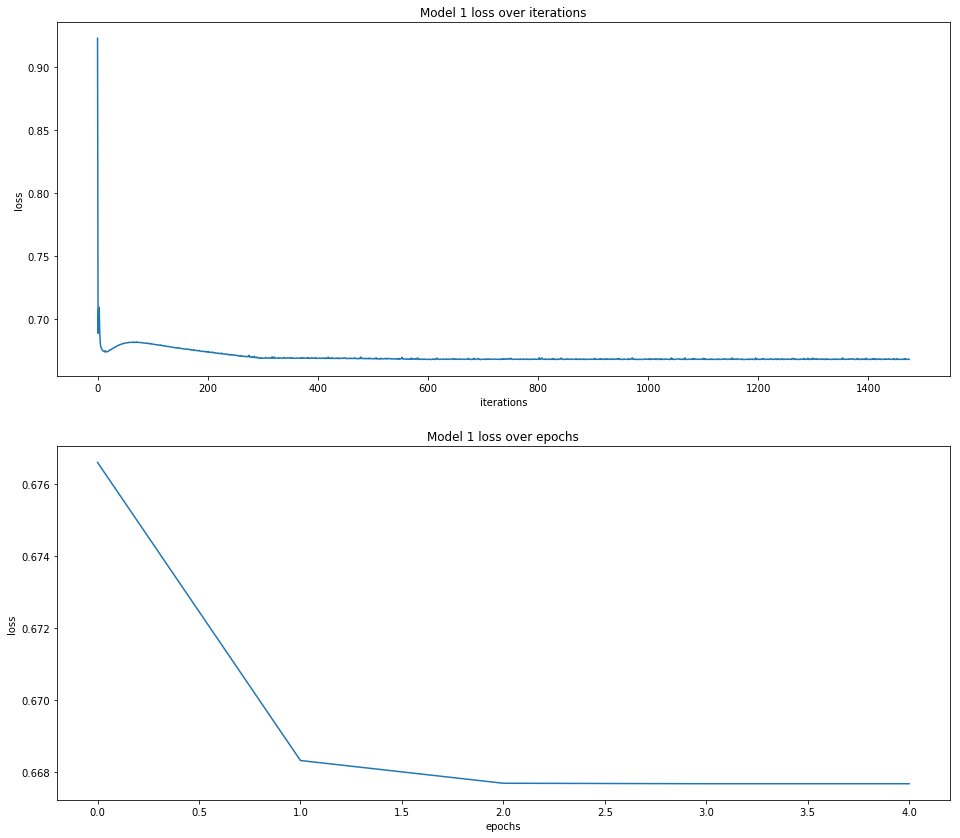

In [54]:
modelfig1 = plt.figure(figsize=(16, 16))
modelfig1.subplots_adjust(top=0.8)
a = modelfig1.add_subplot(211)
a.set_ylabel('loss')
a.set_xlabel('iterations')
a.set_title('Model 1 loss over iterations')
a.plot(all_losses_list_model1)

b = modelfig1.add_subplot(212)
b.set_ylabel('loss')
b.set_xlabel('epochs')
b.set_title('Model 1 loss over epochs')
b.plot(epoch_avg_loss_model1)

plt.show()

## Model 2

Validation loss:

In [25]:
validate_loss_model2_list = list()
with torch.no_grad():
    current_loss = 0
    total_loss = 0
    avg_loss = 0
    for iteration, (input_image, target_image) in enumerate(val_dataloader):
        
        output_img = model2(input_image.permute(0,3,2,1).to(device))
        target_img = target_image.unsqueeze(1).to(device)

        loss = criterion(output_img, target_img)
        
        current_loss = float(loss.item())
        total_loss += current_loss
        avg_loss = total_loss / (iteration+1)
        validate_loss_model2_list.append(current_loss)



Mean-squared error for validation set:

In [26]:
sum(np.array(validate_loss_model2_list)**2)

29.402526120896386

Test loss:

In [29]:
test_loss_model2_list = list()
with torch.no_grad():
    current_loss = 0
    total_loss = 0
    avg_loss = 0
    for iteration, (input_image, target_image) in enumerate(test_dataloader):
        
        output_img = model2(input_image.permute(0,3,2,1).to(device))
        target_img = target_image.unsqueeze(1).to(device)

        loss = criterion(output_img, target_img)
        
        current_loss = float(loss.item())
        total_loss += current_loss
        avg_loss = total_loss / (iteration+1)
        test_loss_model2_list.append(current_loss)

Mean-squared error for test set:

In [30]:
sum(np.array(test_loss_model2_list)**2)

29.402192702332542

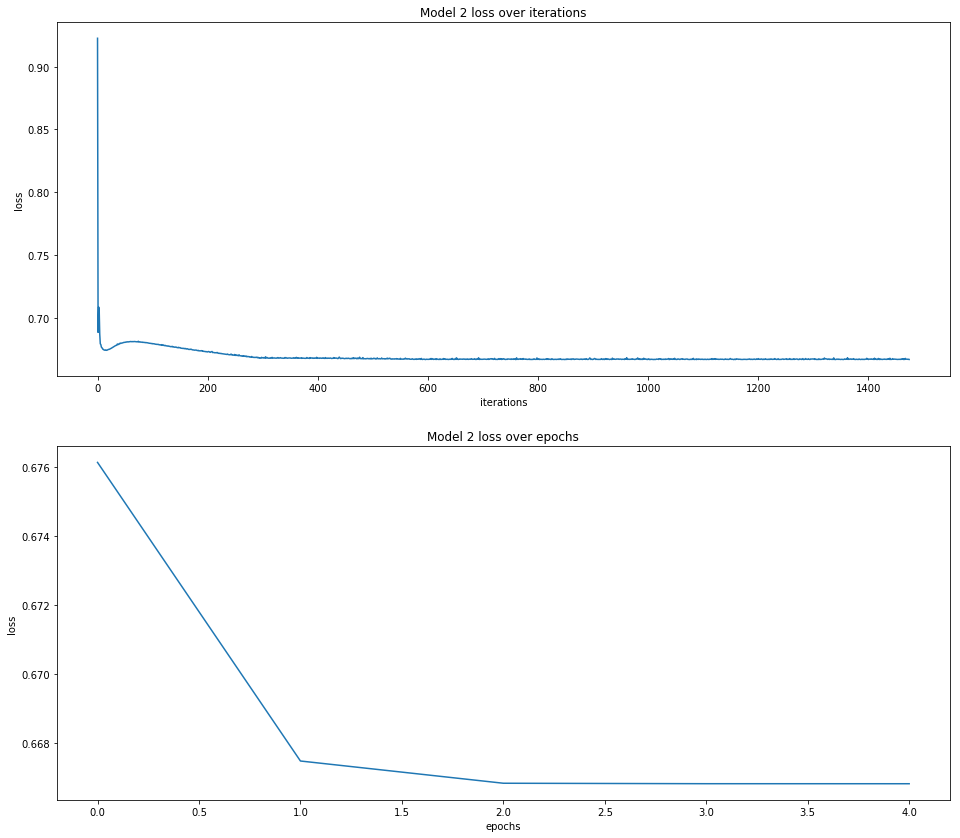

In [55]:
modelfig2 = plt.figure(figsize=(16, 16))
modelfig2.subplots_adjust(top=0.8)
a = modelfig2.add_subplot(211)
a.set_ylabel('loss')
a.set_xlabel('iterations')
a.set_title('Model 2 loss over iterations')
a.plot(all_losses_list_model2)

b = modelfig2.add_subplot(212)
b.set_ylabel('loss')
b.set_xlabel('epochs')
b.set_title('Model 2 loss over epochs')
b.plot(epoch_avg_loss_model2)

plt.show()

# Additional:
## Inspect the output from the model by choosing any arbitrary image from the output of the test set. 
We could also do this for any other set

The following makes our images in the format we want for displaying. 

In [57]:
model1.eval()
model2.eval()
input_images = list()
model1_outputs = list()
model2_outputs = list()
gold_outputs = list()

with torch.no_grad():
    for iteration, (input_image, target_image) in enumerate(test_dataloader):
        try:
            output_img_model1 = model1(input_image.permute(0,3,2,1).to(device))
            output_img_model2 = model2(input_image.permute(0,3,2,1).to(device))
        except:
            pass
        
        for i in range(batch_size):
            input_images.append(input_image[i].cpu().numpy().astype(np.uint))
            model1_outputs.append(output_img_model1[i].cpu().squeeze().numpy())
            model2_outputs.append(output_img_model2[i].cpu().squeeze().numpy())
            gold_outputs.append(target_image[i].cpu().squeeze().numpy())
            

We then choose and display the images. 

Example from model 1:

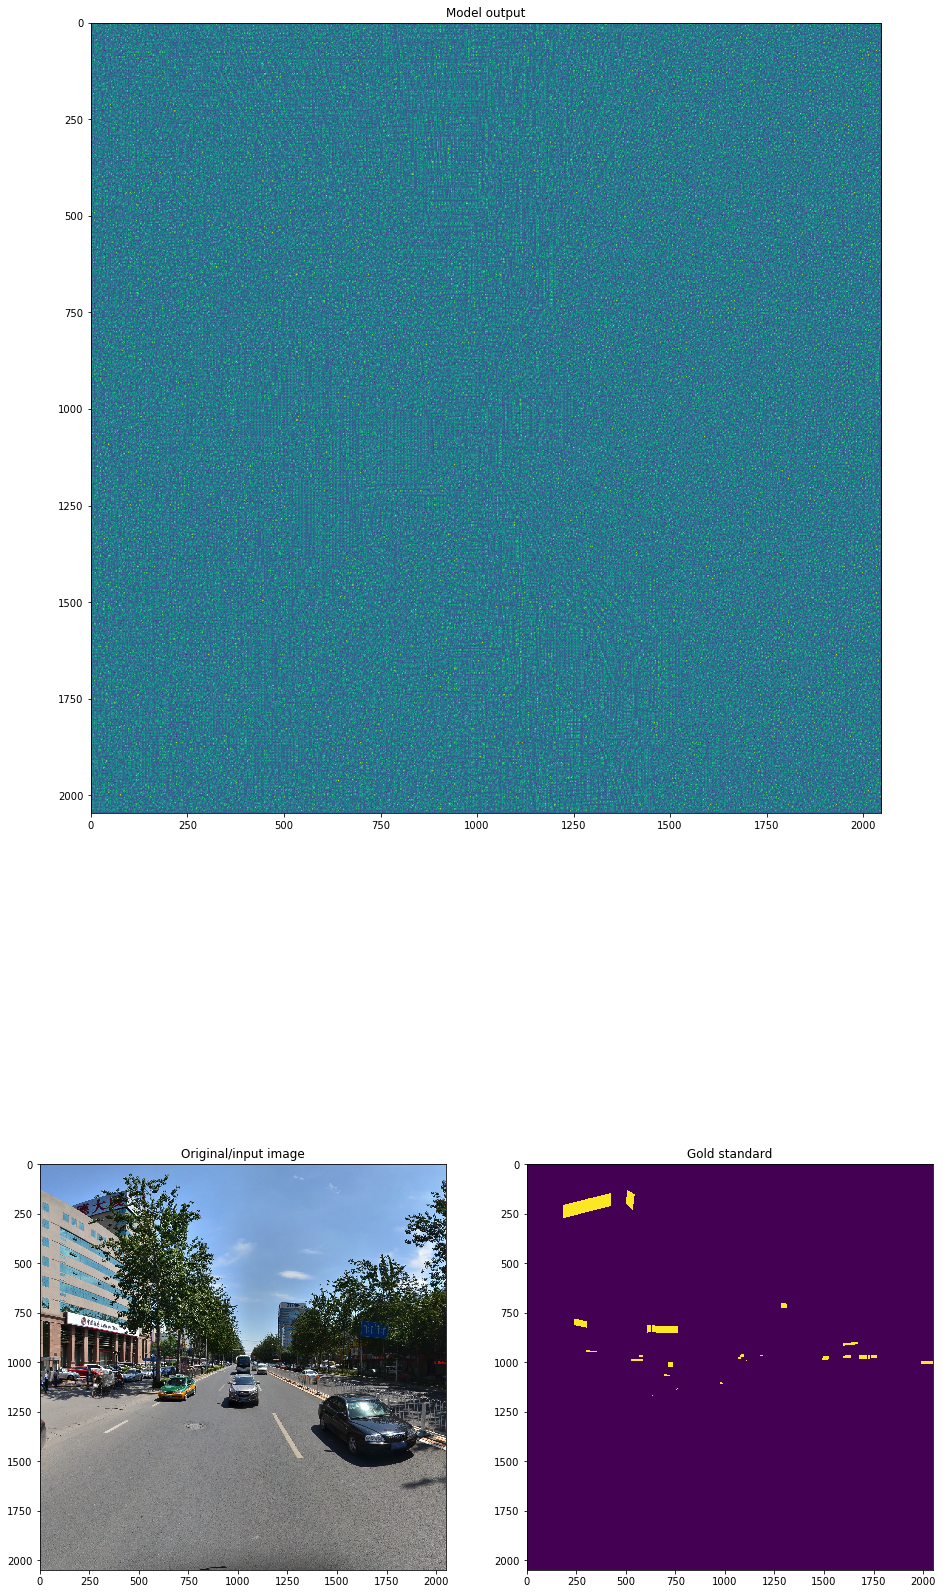

In [58]:
image_index = 2

fig = plt.figure(figsize=(16, 32))
pic1 = fig.add_subplot(223)
plt.imshow(input_images[image_index])
pic1.set_title('Original/input image')
pic2 = fig.add_subplot(211)
plt.imshow(model1_outputs[image_index])
pic2.set_title('Model output')
pic3 = fig.add_subplot(224)
plt.imshow(gold_outputs[image_index])
pic3.set_title('Gold standard')
plt.show()

Example from model 2:

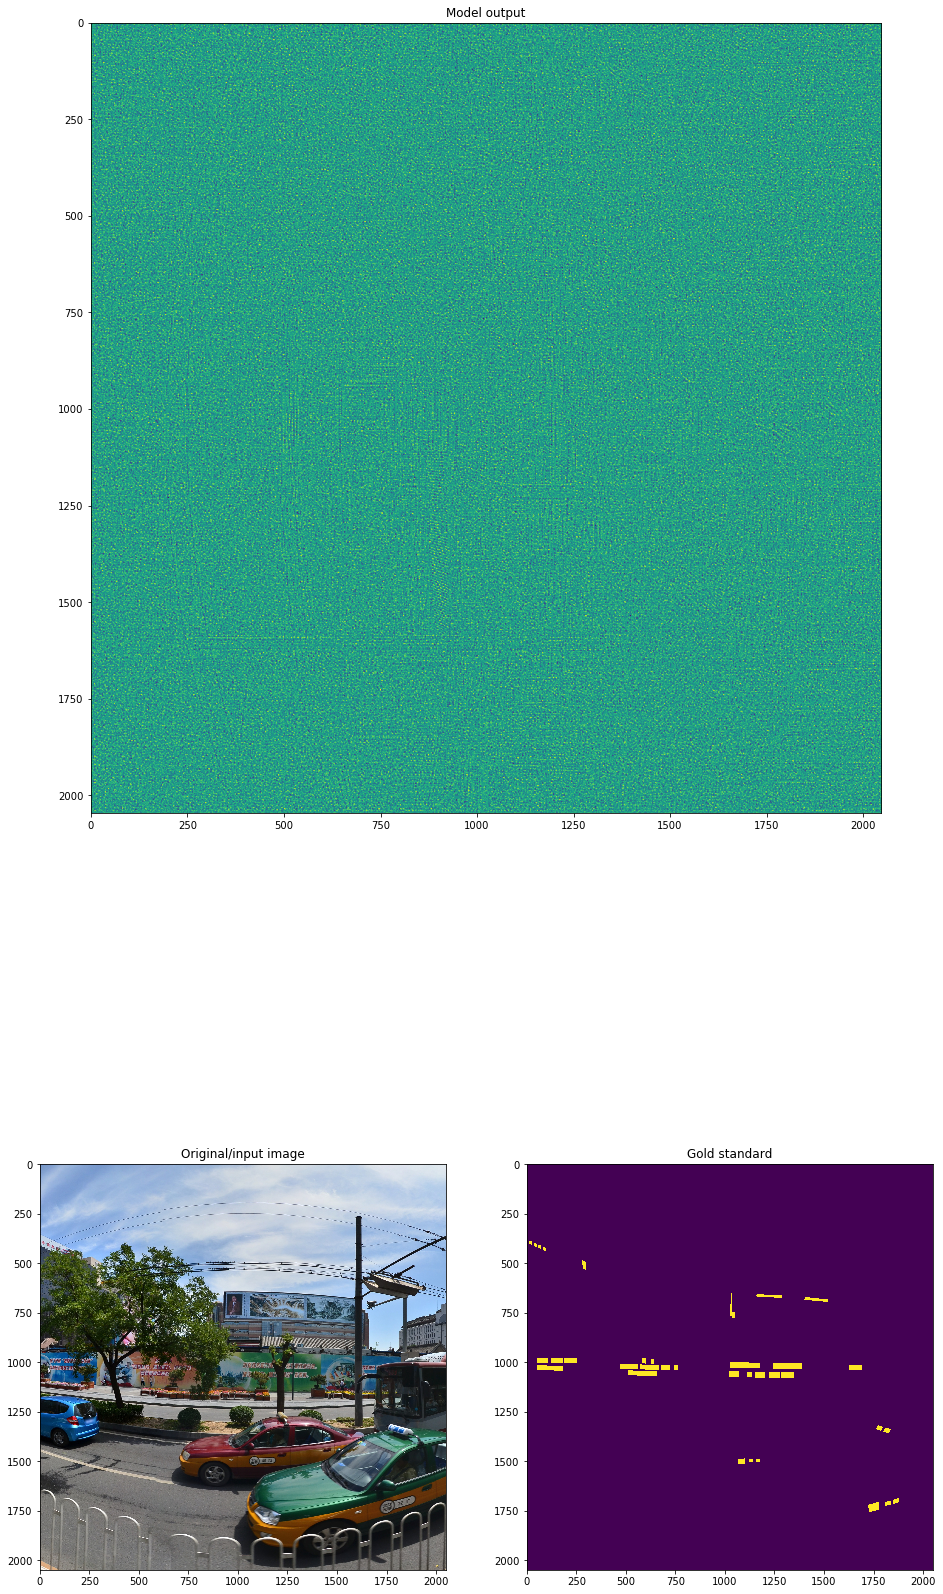

In [59]:
image_index = 3

fig = plt.figure(figsize=(16, 32))
pic1 = fig.add_subplot(223)
plt.imshow(input_images[image_index])
pic1.set_title('Original/input image')
pic2 = fig.add_subplot(211)
plt.imshow(model2_outputs[image_index])
pic2.set_title('Model output')
pic3 = fig.add_subplot(224)
plt.imshow(gold_outputs[image_index])
pic3.set_title('Gold standard')
plt.show()